In [1]:
import os.path as op

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from scipy.io import loadmat
from scipy.stats import ttest_ind, ttest_rel, pearsonr

from neurodsp.utils.norm import normalize_sig

from timescales.fit import PSD
from timescales.autoreg import compute_ar_spectrum
from timescales.plts import set_default_rc
from timescales.utils import create_windows

set_default_rc()

# Figure 4. Sleep vs. Wake
The timescales, as knee frequencies, are compared between 4 types of spike trains and the local field potential:

- Wake : Excitatory Units
- NREM : Excitatory Units
- Wake : Inhibitory Units
- NREM : Inhibitory Units


- LFP Wake
- LFP NREM

In [2]:
def compute_spectra_trials(spikes_e, spikes_i, start_end, f_range,
                           bin_size, ar_order, kwargs_ar=None):
    """Compute Welch's and AR PSD for exciatatory and inhibitory spikes."""
    
    # Ensure unpackable
    if kwargs_ar is None:
        kwargs_ar = {}
            
    # Compute AR-PSD and Welch's-PSD for each window
    for ind, (s, e) in enumerate(start_end):

        # Normalize
        spikes_bin_e = normalize_sig(
            spikes_e[s:e].reshape(-1, bin_size).sum(axis=1), 0, 1)
        
        spikes_bin_i = normalize_sig(
            spikes_i[s:e].reshape(-1, bin_size).sum(axis=1), 0, 1)
        
        # Compute excitatory spectra
        freqs_ar, powers_ar_e = compute_ar_spectrum(spikes_bin_e, fs/bin_size, ar_order,
                                                    f_range=f_range, **kwargs_ar)
        
        # Compute inhibitory spectra
        _, powers_ar_i = compute_ar_spectrum(spikes_bin_i, fs/bin_size, ar_order,
                                             f_range=f_range, **kwargs_ar)
        
        # Initalize arrays
        if ind == 0:
            
            freqs = {'ar': freqs_ar}
            
            powers = {
                'ar': {'excitatory': np.zeros((len(start_end), len(powers_ar_e))),
                       'inhibitory': np.zeros((len(start_end), len(powers_ar_i)))}
            }
            
        powers['ar']['excitatory'][ind] = powers_ar_e
        powers['ar']['inhibitory'][ind] = powers_ar_i
        
    return freqs, powers

In [3]:
# Load data
base_name = '20140526_277um'
dir_path = f'/home/rph/Projects/timescale-methods/fcx1/{base_name}'

subtype_dict = loadmat(f'{dir_path}/{base_name}_SSubtypes.mat')
subtype_e = subtype_dict['Se_CellFormat'][0]
subtype_i = subtype_dict['Si_CellFormat'][0]

fs = 20000

n_seconds = np.ceil(max([*[np.max(i) for i in subtype_i], 
                         *[np.max(i) for i in subtype_e]]))

times = np.arange(0, n_seconds, 1/fs)

# Extract behavioral data
beh_file = f'{dir_path}/{base_name}_WSRestrictedIntervals.mat'
beh = loadmat(beh_file)

nrem = beh['SWSPacketTimePairFormat'].astype(int) * fs
wake = beh['WakeTimePairFormat'].astype(int) *  fs

# Window by trial type
win_len = int(5*fs)
win_spacing = int(5*fs)

wake_starts, wake_mids, wake_ends = create_windows(wake, win_len, win_spacing)
nrem_starts, nrem_mids, nrem_ends = create_windows(nrem, win_len, win_spacing)

start_end_wake = np.vstack((wake_starts, wake_ends)).T
start_end_nrem = np.vstack((nrem_starts, nrem_ends)).T

### AR-PSD

The AR spectra are influences by the bin size and the AR order parameters. These parameters will influence the resulting timescales measurements. These spectra follow a Lorentzian form.

In [4]:
# Sum spikes across E/I sub-units
spikes = np.zeros((2, int(n_seconds * fs)))
                    
for sind, subtype in enumerate([subtype_e, subtype_i]):
    for s in subtype:
        spikes[sind, (s[:, 0] * fs).astype(int)] = 1

spikes_e = spikes[0]
spikes_i = spikes[1]

# Compute Spectra
f_range = (0, 100)
bin_size = 200
ar_order = 5

freqs_wake, powers_wake = compute_spectra_trials(
    spikes_e, spikes_i, start_end_wake, f_range, bin_size, ar_order
)

freqs_nrem, powers_nrem = compute_spectra_trials(
    spikes_e, spikes_i, start_end_nrem, f_range, bin_size, ar_order
)

### Fit Spectra: Spikes

In [5]:
fooof_init = {
    'aperiodic_mode': 'knee_constant',
    'max_n_peaks': 4,
    'peak_threshold': 2.5
}

bounds = [
    [-10, 1e-3, 1e-3, 1e-20],
    [ 10, 20,     10,  1e-2]
]

guess = [-2, 1, 1, 1e-2]

psd_ex_nrem = PSD(freqs_nrem['ar'], powers_nrem['ar']['excitatory'])
psd_ex_nrem.fit(method='fooof', fooof_init=fooof_init, bounds=bounds, guess=guess,
                n_jobs=-1, progress='tqdm.notebook')

psd_in_nrem = PSD(freqs_nrem['ar'], powers_nrem['ar']['inhibitory'])
psd_in_nrem.fit(method='fooof', fooof_init=fooof_init, bounds=bounds, guess=guess,
                n_jobs=-1, progress='tqdm.notebook')

psd_ex_wake = PSD(freqs_wake['ar'], powers_wake['ar']['excitatory'])
psd_ex_wake.fit(method='fooof', fooof_init=fooof_init, bounds=bounds, guess=guess,
                n_jobs=-1, progress='tqdm.notebook')

psd_in_wake = PSD(freqs_wake['ar'], powers_wake['ar']['inhibitory'])
psd_in_wake.fit(method='fooof', fooof_init=fooof_init, bounds=bounds, guess=guess,
                n_jobs=-1, progress='tqdm.notebook')

Running FOOOFGroup:   0%|          | 0/536 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/536 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/427 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/427 [00:00<?, ?it/s]

### Spike Stats

The NREM trials have a significantly higher r-squared values, compared to the wake trails. Comparing the timescales between the two may be confounded by this.

In [6]:
# R-squared stats
print('Spike R-Squared Statistics\n')
print('Excitatory Wake: ', 'mean =', psd_ex_wake.rsq_full.mean(),
      'std =', psd_ex_wake.rsq_full.std())
print('Excitatory NREM: ', 'mean =', psd_ex_nrem.rsq_full.mean(),
      'std =', psd_ex_nrem.rsq_full.std())
print('Inhibitory Wake: ', 'mean =', psd_in_wake.rsq_full.mean(),
      'std =', psd_in_wake.rsq_full.std())
print('Inhibitory NREM: ', 'mean =', psd_in_nrem.rsq_full.mean(), 
      'std =', psd_in_nrem.rsq_full.std())
print()
print('Excitatory: Wake vs NREM')
print(ttest_ind(psd_ex_wake.rsq_full, psd_ex_nrem.rsq_full))
print()
print('Inhibitory: Wake vs NREM')
print(ttest_ind(psd_in_wake.rsq_full, psd_in_nrem.rsq_full))
print()
print('Wake: Excitatory vs Inhibitory')
print(ttest_ind(psd_ex_wake.rsq_full, psd_in_wake.rsq_full))
print()
print('NREM: Excitatory vs Inhibitory')
print(ttest_ind(psd_ex_nrem.rsq_full, psd_in_nrem.rsq_full))

Spike R-Squared Statistics

Excitatory Wake:  mean = 0.8237961930445714 std = 0.2165613580105497
Excitatory NREM:  mean = 0.9551133739885479 std = 0.0603757437890658
Inhibitory Wake:  mean = 0.7760963792622833 std = 0.23944804910263517
Inhibitory NREM:  mean = 0.9661529198146298 std = 0.04790972635594994

Excitatory: Wake vs NREM
Ttest_indResult(statistic=-13.386164016678734, pvalue=1.35224023375709e-37)

Inhibitory: Wake vs NREM
Ttest_indResult(statistic=-17.912471149298536, pvalue=3.90499537291248e-62)

Wake: Excitatory vs Inhibitory
Ttest_indResult(statistic=3.0494139674328213, pvalue=0.0023638115434466036)

NREM: Excitatory vs Inhibitory
Ttest_indResult(statistic=-3.312942925626916, pvalue=0.0009541012302210045)


In [7]:
# Knee freq stats
print('Spike Knee Frequency Statistics\n')

print('Excitatory Wake: ', 'mean =', psd_ex_wake.knee_freq.mean(),
      'std =', psd_ex_wake.knee_freq.std())
print('Excitatory NREM: ', 'mean =', psd_ex_nrem.knee_freq.mean(),
      'std =', psd_ex_nrem.knee_freq.std())
print('Inhibitory Wake: ', 'mean =', psd_in_wake.knee_freq.mean(),
      'std =', psd_in_wake.knee_freq.std())
print('Inhibitory NREM: ', 'mean =', psd_in_nrem.knee_freq.mean(), 
      'std =', psd_in_nrem.knee_freq.std())
print()
print('Excitatory: Wake vs NREM')
print(ttest_ind(psd_ex_wake.knee_freq, psd_ex_nrem.knee_freq))
print()
print('Inhibitory: Wake vs NREM')
print(ttest_ind(psd_in_wake.knee_freq, psd_in_nrem.knee_freq))
print()
print('Wake: Excitatory vs Inhibitory')
print(ttest_ind(psd_ex_wake.knee_freq, psd_in_wake.knee_freq))
print()
print('NREM: Excitatory vs Inhibitory')
print(ttest_ind(psd_ex_nrem.knee_freq, psd_in_nrem.knee_freq))

Spike Knee Frequency Statistics

Excitatory Wake:  mean = 6.510950551944465 std = 4.246369610003782
Excitatory NREM:  mean = 4.648572040370361 std = 2.09479811903976
Inhibitory Wake:  mean = 4.9346724778701345 std = 2.5163170714229937
Inhibitory NREM:  mean = 4.060590712098375 std = 1.993919717180862

Excitatory: Wake vs NREM
Ttest_indResult(statistic=8.877601649374666, pvalue=3.2896066288641537e-18)

Inhibitory: Wake vs NREM
Ttest_indResult(statistic=6.00776424501637, pvalue=2.6662281322938156e-09)

Wake: Excitatory vs Inhibitory
Ttest_indResult(statistic=6.591249288074879, pvalue=7.637748207776019e-11)

NREM: Excitatory vs Inhibitory
Ttest_indResult(statistic=4.702579432003745, pvalue=2.904517412488611e-06)


### Spikes vs LFPs

Spike versus LFP timescale comparison.

In [8]:
# Load LFP
data_id = '20140526_277um'
data_dir = f'/home/rph/Projects/timescale-methods/fcx1/data_mats/{data_id}'
fs = 1250

# Infer shape using one channel
lfp_file = op.join(data_dir, 'data01.mat')
sig_len = len(loadmat(lfp_file)['data'][0])

# Get PFC channels
channels = list(range(17, 49))
sig_lfp = np.zeros(sig_len)

for cind, ch in enumerate(channels):
    lfp_file = op.join(data_dir, f'data{ch}.mat')
    sig_lfp += loadmat(lfp_file)['data'][0]

sig_lfp = sig_lfp / len(channels)
sig_lfp =  normalize_sig(sig_lfp, 0, 1)

times = np.arange(0, len(sig_lfp)/fs, 1/fs)

# Windows
nrem = beh['SWSPacketTimePairFormat'].astype(int) * fs
wake = beh['WakeTimePairFormat'].astype(int) * fs

# Window by trial type
win_len = int(5*fs)
win_spacing = int(5*fs)

wake_starts, wake_mids, wake_ends = create_windows(wake, win_len, win_spacing)
nrem_starts, nrem_mids, nrem_ends = create_windows(nrem, win_len, win_spacing)

start_end_wake = np.vstack((wake_starts, wake_ends)).T
start_end_nrem = np.vstack((nrem_starts, nrem_ends)).T

# Create 2d arrays
sig_lfp_wake = np.array([sig_lfp[s:e] for s, e in
                         zip(wake_starts, wake_ends)])

sig_lfp_nrem = np.array([sig_lfp[s:e] for s, e in
                         zip(nrem_starts, nrem_ends)])

### Fit Spectra: LFP

In [9]:
fooof_init = {
    'aperiodic_mode': 'knee_constant',
    'max_n_peaks': 4,
    'peak_threshold': 2.5
}

bounds = [
    [-10, 1e-3, 1e-3, 1e-20],
    [ 10, 20,     10,  1e-2]
]

guess = [-2, 1, 1, 1e-2]

psd_lfp_wake = PSD()
psd_lfp_wake.compute_spectrum(sig_lfp_wake, fs, f_range=(0, 100), ar_order=10)
psd_lfp_wake.fit(method='fooof', fooof_init=fooof_init, bounds=bounds, guess=guess,
                 n_jobs=-1, progress='tqdm.notebook')

psd_lfp_nrem = PSD()
psd_lfp_nrem.compute_spectrum(sig_lfp_nrem, fs, f_range=(0, 100), ar_order=10)
psd_lfp_nrem.fit(method='fooof', fooof_init=fooof_init, bounds=bounds, guess=guess,
                 n_jobs=-1, progress='tqdm.notebook')

Running FOOOFGroup:   0%|          | 0/427 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/536 [00:00<?, ?it/s]

### Plot

In [10]:
def plot_overlapping_densities(df, xlim, overlap_hspace=-.5):
    
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(6, rot=-.25, light=.5)
    
    grid = sns.FacetGrid(df, row="labels", hue="labels", aspect=10,
                         height=2, palette=pal, xlim=xlim)

    # Draw the densities in a few steps
    grid.map(sns.kdeplot, "knees", clip_on=True,
             fill=True, alpha=1, linewidth=2)
   
    grid.map(sns.kdeplot, "knees", clip_on=True, color="w", lw=2.5, bw_adjust=1)

    grid.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

    # Label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes, size=20)

    grid.map(label, "knees")

    # Set the subplots to overlap
    grid.figure.subplots_adjust(hspace=overlap_hspace)

    # Remove axes details that don't play well with overlap
    grid.set_titles("")
    grid.set(yticks=[], ylabel="")
    grid.set(xticks=np.arange(0, xlim[1]+1))
    grid.despine(bottom=False, left=True)
    
    grid.set_xticklabels(np.arange(0, xlim[1]+1), size=24)
    grid.set_xlabels('Knee Frequency (Hertz)', size=28)
    
    return grid

In [11]:
import pandas as pd

# Apply r-squared threshold
rsq_thresh = .25

nrem_inds = np.where(
    (psd_ex_nrem.rsq > rsq_thresh) &
    (psd_in_nrem.rsq > rsq_thresh) &
    (psd_lfp_nrem.rsq > rsq_thresh)
)[0]

wake_inds = np.where(
    (psd_ex_wake.rsq > rsq_thresh) &
    (psd_in_wake.rsq > rsq_thresh) &
    (psd_lfp_wake.rsq > rsq_thresh)
)[0]

# Merge knees
knees = np.concatenate([
    psd_lfp_nrem.knee_freq[nrem_inds],
    psd_ex_nrem.knee_freq[nrem_inds],
    psd_in_nrem.knee_freq[nrem_inds],
    psd_lfp_wake.knee_freq[wake_inds],
    psd_ex_wake.knee_freq[wake_inds],
    psd_in_wake.knee_freq[wake_inds]
])

# Merge labels
labels = [
    *['LFP : NREM'] * len(nrem_inds),
    *['Spikes : Excitatory : NREM'] * len(nrem_inds),
    *['Spikes : Inhibitory : NREM'] * len(nrem_inds),
    *['LFP : Wake'] * len(wake_inds),
    *['Spikes : Excitatory : Wake'] * len(wake_inds),
    *['Spikes : Inhibitory : Wake'] * len(wake_inds)
]

# To dataframe
df = pd.DataFrame(dict(knees=knees, labels=labels))

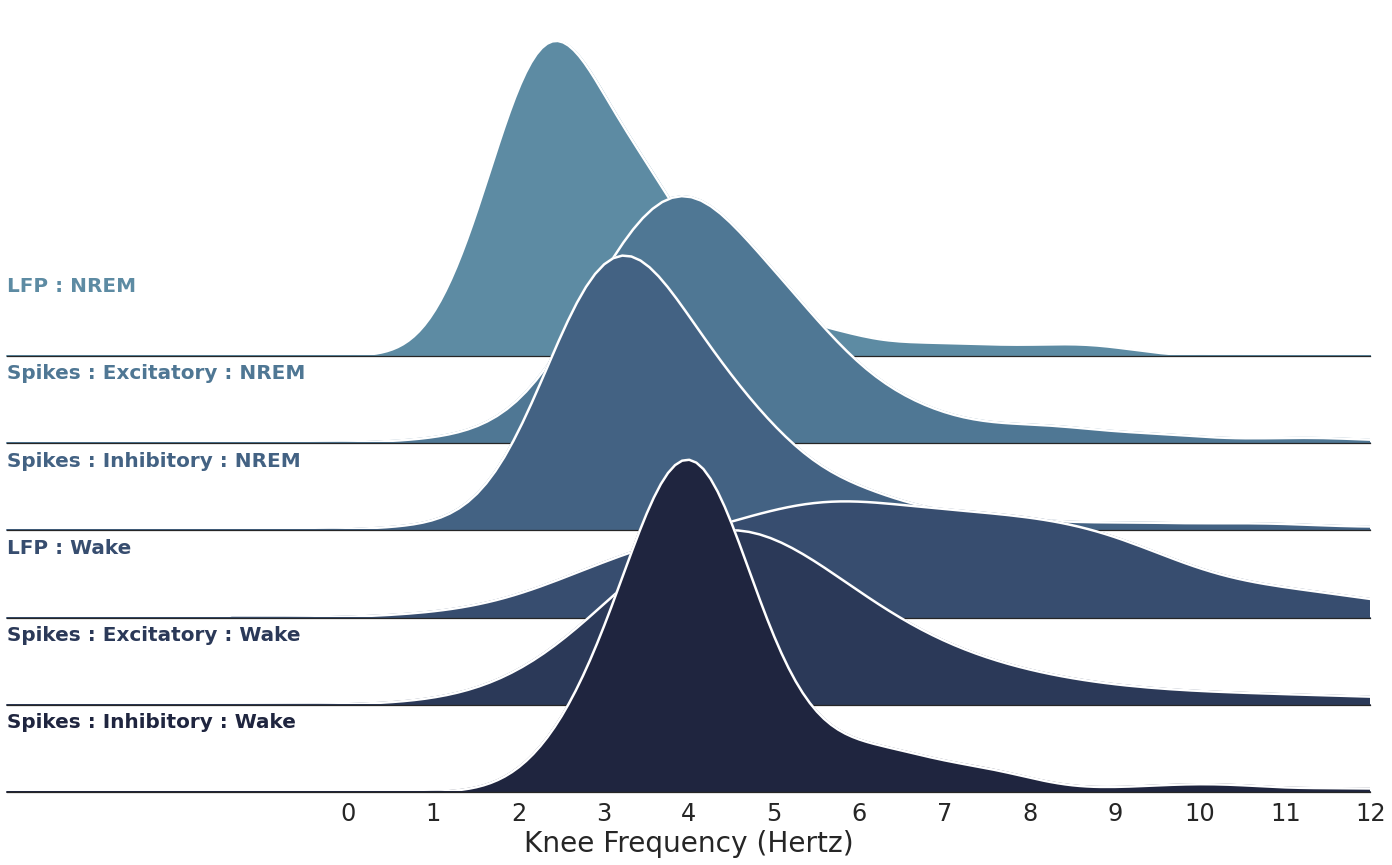

In [13]:
# Plot
plot_overlapping_densities(df, (-4, 12), overlap_hspace=-0.75)

plt.savefig('fig05_sleep_vs_wake.png', dpi=300, facecolor='w');

In [14]:
print('Wake')
print(f'LFP               : mean={psd_lfp_wake.knee_freq[wake_inds].mean()}, '\
      f'std={psd_lfp_wake.knee_freq[wake_inds].std()}')

print(f'Spikes, Excitatory: mean={psd_ex_wake.knee_freq[wake_inds].mean()}, '\
      f'std={psd_ex_wake.knee_freq[wake_inds].std()}')

print(f'Spikes, Inhibitory: mean={psd_in_wake.knee_freq[wake_inds].mean()}, '\
      f'std={psd_in_wake.knee_freq[wake_inds].std()}')

print()

print(f'NREM')

print(f'LFP               : mean={psd_lfp_nrem.knee_freq[nrem_inds].mean()}, '\
      f'std={psd_lfp_nrem.knee_freq[nrem_inds].std()}')

print(f'Spikes, Excitatory: mean={psd_ex_nrem.knee_freq[nrem_inds].mean()}, '\
      f'std={psd_ex_nrem.knee_freq[nrem_inds].std()}')

print(f'Spikes, Inhibitory: mean={psd_in_nrem.knee_freq[nrem_inds].mean()}, '\
      f'std={psd_in_nrem.knee_freq[nrem_inds].std()}')

Wake
LFP               : mean=6.8001364891954, std=2.656403888980302
Spikes, Excitatory: mean=6.15023882411311, std=3.816180868647709
Spikes, Inhibitory: mean=4.5061781442512405, std=1.6995762892176098

NREM
LFP               : mean=3.1374131726642167, std=1.4539461558915583
Spikes, Excitatory: mean=4.622147400058879, std=2.005520664967615
Spikes, Inhibitory: mean=4.061209976351796, std=1.9957308268995413


In [15]:
print('Wake vs NREM')
print('LFP       : ', ttest_ind(psd_lfp_wake.knee_freq[wake_inds],
                                psd_lfp_nrem.knee_freq[nrem_inds]))

print('Excitatory: ', ttest_ind(psd_ex_wake.knee_freq[wake_inds],
                                psd_ex_nrem.knee_freq[nrem_inds]))

print('Inhibitory: ', ttest_ind(psd_in_wake.knee_freq[wake_inds],
                                psd_in_nrem.knee_freq[nrem_inds]))
 
print()
print('Wake')
print('LFP vs Excitatory:', ttest_rel(psd_lfp_wake.knee_freq[wake_inds],
                                      psd_ex_wake.knee_freq[wake_inds]))

print('LFP vs Inhibitory:', ttest_rel(psd_lfp_wake.knee_freq[wake_inds],
                                      psd_in_wake.knee_freq[wake_inds]))
print()
print(f'NREM')
print('LFP vs Excitatory:', ttest_rel(psd_lfp_nrem.knee_freq[nrem_inds],
                                      psd_ex_nrem.knee_freq[nrem_inds]))

print('LFP vs Inhibitory:', ttest_rel(psd_lfp_nrem.knee_freq[nrem_inds],
                                      psd_in_nrem.knee_freq[nrem_inds]))

Wake vs NREM
LFP       :  Ttest_indResult(statistic=26.21179265308087, pvalue=4.76513474449946e-112)
Excitatory:  Ttest_indResult(statistic=7.709989328694835, pvalue=3.438514642092187e-14)
Inhibitory:  Ttest_indResult(statistic=3.38372695420238, pvalue=0.000747082004084111)

Wake
LFP vs Excitatory: Ttest_relResult(statistic=2.576773510327446, pvalue=0.010400209973630595)
LFP vs Inhibitory: Ttest_relResult(statistic=13.76100417988951, pvalue=1.837967809311979e-34)

NREM
LFP vs Excitatory: Ttest_relResult(statistic=-15.57977377129755, pvalue=2.1891548411738475e-45)
LFP vs Inhibitory: Ttest_relResult(statistic=-12.6061404963828, pvalue=4.4365469496275713e-32)


In [16]:
print('Correlation')

print('Wake: LFP vs Excitatory: r={:.4f}, p={:.4f}'.format(
    *pearsonr(psd_lfp_wake.knee_freq[wake_inds], psd_ex_wake.knee_freq[wake_inds]))
)

print('Wake: LFP vs Inhibitory: r={:.4f}, p={:.4f}'.format(
    *pearsonr(psd_lfp_wake.knee_freq[wake_inds], psd_in_wake.knee_freq[wake_inds]))
)

print()

print('NREM: LFP vs Excitatory: r={:.4f}, p={:.4f}'.format(
    *pearsonr(psd_lfp_nrem.knee_freq[nrem_inds], psd_ex_nrem.knee_freq[nrem_inds]))
)

print('NREM: LFP vs Inhibitory: r={:.4f}, p={:.4f}'.format(
    *pearsonr(psd_lfp_nrem.knee_freq[nrem_inds], psd_in_nrem.knee_freq[nrem_inds]))
)

Correlation
Wake: LFP vs Excitatory: r=0.0153, p=0.7802
Wake: LFP vs Inhibitory: r=0.0704, p=0.1979

NREM: LFP vs Excitatory: r=0.2206, p=0.0000
NREM: LFP vs Inhibitory: r=0.5564, p=0.0000
